In [1]:
#imported libraries for basic functions like plotting and matrix manipulation
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(z):
  return 1/(1+np.exp(-1*z))

In [3]:
#Introduction to notations followed
#Train Matrix: X is (n, m): n is the number of features, m is the number of examples
#Labels: y is (1, m)
#Weights: w is (1, n), b is a scalar
#s: is the hyperparameter for Lasso regularization

##################################################### ALL HELPER FUNCTIONS ################################################################
#General Plotter
def plot_curve(y, x_axis, y_axis, title):
  plt.title(title)
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)

  index = np.arange(1, len(y)+1, 1)
  plt.plot(index, y)

  plt.show()

#cost function
def cost(X, y, w, b, s):
  a = sigmoid(w.dot(X) + b)
  #f is the logistic part
  f = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
  #g is the Lasso (L1 regularization) part
  g = s*np.sum(np.abs(w))
  return (f+g)/X.shape[1]

#Defining the subgradient to be 0 (when w_i = 0) (as objective: is to minimize the L1-norm of weights)
def subgrad_L1(w):
  #sign_w stores sign of the components of w: +1 (w>0), -1 (w<0), 0(w=0)
  sign_w = -1*(w<0)+(w>0)
  #subgradient of L1 stores just the signs
  return sign_w

#return the subgradients: only point in which the lasso regularized logistic regression it is not differentiable is at 0. 

def subgradients_lasso_logistic(X, y, w, b, s):
  a = sigmoid(w.dot(X) + b)
  #dw, db represents the partial derivative of the cost function w.r.t dw (gradient vector), db (scalar)
  #vectorized implementation of dw, db
  dw = ((a-y).dot(X.T)+s*subgrad_L1(w))/X.shape[1]
  db = (np.sum(a-y))/X.shape[1]
  return dw, db

##########################################################################################################################################

In [4]:
########################################### Subgradient Descent Algorithm, Train Code ####################################################  
# The same code can be reused for heavy-ball subgradient method and normal subgradient method, by setting beta (beta=0 in the normal case) 
def subgradientDescent(X, y, w0, b0, s, learning_rate, beta, n_iter, decay_flag):
  #initializing the initial weight
  #heavy ball tuning hyperparameter beta
  w_t = w0
  b_t = b0
  #stores the loss over iterations
  loss = []
  #init_loss
  print("Initial loss: "+str(cost(X, y, w_t, b_t, s)))
  loss.append(cost(X, y, w_t, b_t, s))
  
  w_t_1 = w_t
  b_t_1 = b_t

  #w_-1 = w_0, 1st step: no heavy ball (convention)
  dw_t, db_t =  subgradients_lasso_logistic(X, y, w_t, b_t, s)
  w_t = w_t - learning_rate*dw_t
  b_t = b_t - learning_rate*db_t
  loss.append(cost(X, y, w_t, b_t, s))
  
  for i in range(2, 1+n_iter):
    lr = 0
    if decay_flag == False:
      lr = learning_rate
    else:
      #learning rate is a measure of 1/u
      lr = 2*learning_rate/(i+1)

    temp_w_t = w_t
    temp_b_t = b_t

    dw_t, db_t =  subgradients_lasso_logistic(X, y, w_t, b_t, s)
    
    w_t = w_t - lr*dw_t + beta*(w_t - w_t_1)
    b_t = b_t - lr*db_t + beta*(b_t - b_t_1)
    
    w_t_1 = temp_w_t
    b_t_1 = temp_b_t
    
    loss.append(cost(X, y, w_t, b_t, s))
    #if i%100 == 0:
    #  print("Loss after "+str(i)+" iteration: "+str(cost(X, y, w_t, b_t, s)))
  if decay_flag == False:
    plot_curve(loss, "experiment number", "Cost L(w, b)", "Sub-Gradient Descent with fixed learning rate= "+str(learning_rate)+", hyperparameter lambda = "+str(s)+", heavy ball beta ="+str(beta)+", minimized L= "+str(cost(X, y, w_t, b_t, s)))
  else:
    plot_curve(loss, "experiment number", "Cost L(w, b)", "Sub-Gradient Descent with fixed learning rate= 2*"+str(learning_rate)+"/(t+1), hyperparameter lambda = "+str(s)+", heavy ball beta ="+str(beta)+", minimized L= "+str(cost(X, y, w_t, b_t, s)))
  return w_t, b_t

#takes the training data and return learnt weights
def fit_logistic_regression_subgradDescent(X_train, y_train, s, learning_rate, beta, n_iter, decay_flag):
  w0 = np.zeros((1, X_train.shape[0]))
  b0 = 0
  w, b = subgradientDescent(X_train, y_train, w0, b0, s, learning_rate, beta, n_iter, decay_flag)
  return w, b
##########################################################################################################################################

In [5]:
###################################################### Test Code #########################################################################
def make_prediction(X, w, b):
  threshold = 0.5
  y_hat = sigmoid(w.dot(X)+b)
  return (y_hat>0.5)

def test_model(X_test, y_test, w, b, description):
  y_pred = make_prediction(X_test, w, b)
  accuracy = np.sum(y_pred == y_test)/y_test.shape[1]
  # for Truepositive, FP (rows 0 is positive prediction), FN, TN 
  conf_matrix = np.zeros(shape=(2,2))
  for i in range(y_test.shape[1]):
    r = abs(y_pred[0, i] - 1)
    c = abs(y_test[0, i] - 1)
    conf_matrix[r, c] = conf_matrix[r, c] + 1
  
  precision = conf_matrix[0, 0]/(conf_matrix[0, 0] + conf_matrix[0, 1])
  recall = conf_matrix[0, 0]/(conf_matrix[0, 0] + conf_matrix[1, 0] )
  F1_score = 2*precision*recall/(precision + recall)

  #printing the performance
  print(description) 
  print("Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0")
  print(conf_matrix)
  print("Accuracy = "+str(accuracy)+"\n Precision = "+str(precision)+"\n Recall = "+str(recall)+"\n F1_score = "+str(F1_score))
##########################################################################################################################################

In [6]:
#Code to mount to Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
import csv
import pandas as pd
#normalize the data to prevent the gradient descent in a skewed contour
def normalization(X):
  mu = np.mean(X, axis=1).reshape(X.shape[0], 1)
  sigma = np.std(X, axis=1).reshape(X.shape[0], 1)
  X_norm = (X - mu)/sigma
  return X_norm

def divideDataset(data, labels, n_test):
  #generates a permutation to shuffle the dataset
  permute_order = np.random.permutation(labels.shape[1])
  #reorders the dataset
  data = data[:, permute_order]
  labels = labels[:, permute_order]

  #first m-n_test is stored as train_X
  train_X = data[:, :-n_test]
  train_y = labels[:, :-n_test]

  #test set produced
  test_X = data[:, (data.shape[1] - n_test):]
  test_y = labels[:, (data.shape[1] - n_test):]

  return train_X, train_y, test_X, test_y


#breast cancer classification
def breast_cancer_classification(learning_rate, beta, s, n_iter, decay_flag, algorithm_no):
  data_frame = pd.read_csv('gdrive/MyDrive/Optimizations_for_ML_E1_260/Project1_Dataset/BreastCancer_dataset.csv')
  #stores all the features names (if required for later analysis)
  col_name = data_frame.columns[2:-1]
  #print(col_name)
  
  data = data_frame.to_numpy()
  #removing 1st and 2nd column as they are id and labels. The last column is removed as it has no entry
  data = data[:, 2:-1].T.astype('float64')
  data = normalization(data)
  #print(data.shape)

  #data is (n, m) and (1, m) is for labels
  labels = np.array((data_frame['diagnosis']=='M').astype('int'))
  labels = labels.reshape((1, labels.shape[0]))
  #print(labels.shape)
  
  train_X, train_y, test_X, test_y = divideDataset(data, labels, 70) 
  print("Number of Malignent examples in the training set, test set: "+str(np.sum(train_y))+", "+str(np.sum(test_y)))

  #Train model
  #1 for logistic an 2 for mirror descent
  if algorithm_no == 1:
    w, b = fit_logistic_regression_subgradDescent(train_X, train_y, s, learning_rate, beta, n_iter, decay_flag)
  if algorithm_no == 2:
    w, b = fit_logistic_regression_mirrorDescent(train_X, train_y, s, learning_rate, beta, n_iter, decay_flag)
  #prints the learnt weights
  print(pd.DataFrame(w[0, :], index=col_name, columns=['leant_weight']))
  
  #test performance of the trained model
  test_model(train_X, train_y, w, b, "Performance on the train set")
  test_model(test_X, test_y, w, b, "Performance on the test set")



#Diabetes classification
def Diabetes_classification(learning_rate, beta, s, n_iter, decay_flag, algorithm_no):
  data_frame = pd.read_csv('gdrive/MyDrive/Optimizations_for_ML_E1_260/Project1_Dataset/Diabetes_dataset.csv')
  #stores all the features names (if required for later analysis)
  col_name = data_frame.columns[:-1]
  #print(col_name)
  
  data = data_frame.to_numpy()
  #the last column is the outcome: 1 for diabetes
  labels = data[:, -1].astype('int').reshape((1, data.shape[0]))
  data = data[:, :-1].T.astype('float64')
  #data is (n, m) and (1, m) is for labels
  
  data = normalization(data)
  train_X, train_y, test_X, test_y = divideDataset(data, labels, 100) 
  
  print("Number of examples in the training set, test set with diabetes: "+str(np.sum(train_y))+", "+str(np.sum(test_y)))

  # Train the model
  if algorithm_no == 1:
    w, b = fit_logistic_regression_subgradDescent(train_X, train_y, s, learning_rate, beta, n_iter, decay_flag)
  if algorithm_no == 2:
    w, b = fit_logistic_regression_mirrorDescent(train_X, train_y, s, learning_rate, beta, n_iter, decay_flag)

  #prints the learnt weights
  print(pd.DataFrame(w[0, :], index=col_name, columns=['leant_weight']))

  #test performance of the trained model
  test_model(train_X, train_y, w, b, "Performance on the train set")
  test_model(test_X, test_y, w, b, "Performance on the test set")
  


#Heart Failure classification
def heart_failure_classification(learning_rate, beta, s, n_iter, decay_flag, algorithm_no):
  data_frame = pd.read_csv('gdrive/MyDrive/Optimizations_for_ML_E1_260/Project1_Dataset/HeartFailure_dataset.csv')
  #stores all the features names (if required for later analysis)
  col_name = data_frame.columns[:-1]
  #print(col_name)
  
  data = data_frame.to_numpy()
  #the last column is the outcome: 1 for diabetes
  labels = data[:, -1].astype('int').reshape((1, data.shape[0]))
  data = data[:, :-1].T.astype('float64')
  #data is (n, m) and (1, m) is for labels
  
  data = normalization(data)
  train_X, train_y, test_X, test_y = divideDataset(data, labels, 50) 
  
  print("Number of examples in the training set, test set with with death in heart failure: "+str(np.sum(train_y))+", "+str(np.sum(test_y)))

  # Train the model
  if algorithm_no == 1:
    w, b = fit_logistic_regression_subgradDescent(train_X, train_y, s, learning_rate, beta, n_iter, decay_flag)
  if algorithm_no == 2:
    w, b = fit_logistic_regression_mirrorDescent(train_X, train_y, s, learning_rate, beta, n_iter, decay_flag)

  #prints the learnt weights
  print(pd.DataFrame(w[0, :], index=col_name, columns=['leant_weight']))

  #test performance of the trained model
  test_model(train_X, train_y, w, b, "Performance on the train set")
  test_model(test_X, test_y, w, b, "Performance on the test set")

***********************************WITH FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL************************************************************
Without heavy ball, Without Lasso Regularization
Number of Malignent examples in the training set, test set: 190, 22
Initial loss: 0.6931471805599454


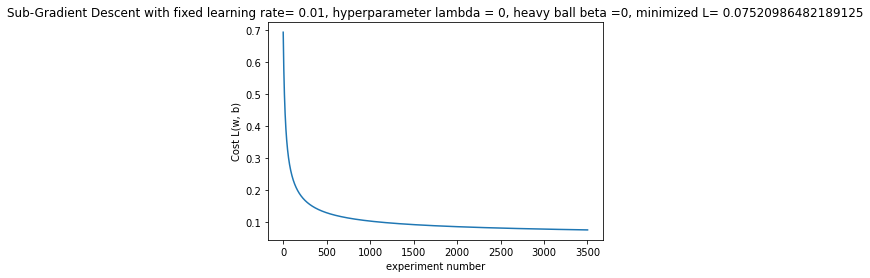

                         leant_weight
radius_mean                  0.509520
texture_mean                 0.521094
perimeter_mean               0.499096
area_mean                    0.509550
smoothness_mean              0.193886
compactness_mean             0.064128
concavity_mean               0.432857
concave points_mean          0.542925
symmetry_mean                0.124769
fractal_dimension_mean      -0.255773
radius_se                    0.527033
texture_se                   0.037989
perimeter_se                 0.423390
area_se                      0.457174
smoothness_se                0.055874
compactness_se              -0.301616
concavity_se                -0.097689
concave points_se            0.089769
symmetry_se                 -0.163686
fractal_dimension_se        -0.306268
radius_worst                 0.646450
texture_worst                0.687886
perimeter_worst              0.603492
area_worst                   0.609687
smoothness_worst             0.489482
compactness_

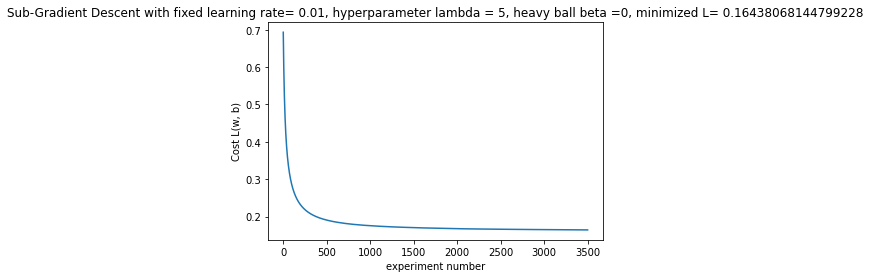

                         leant_weight
radius_mean                  0.404538
texture_mean                 0.352472
perimeter_mean               0.392400
area_mean                    0.382637
smoothness_mean              0.004763
compactness_mean            -0.000075
concavity_mean               0.195717
concave points_mean          0.433170
symmetry_mean               -0.000022
fractal_dimension_mean      -0.022153
radius_se                    0.375110
texture_se                  -0.000070
perimeter_se                 0.240157
area_se                      0.276044
smoothness_se                0.000012
compactness_se              -0.018745
concavity_se                -0.000063
concave points_se            0.000089
symmetry_se                 -0.000147
fractal_dimension_se        -0.117969
radius_worst                 0.568198
texture_worst                0.493520
perimeter_worst              0.521166
area_worst                   0.497263
smoothness_worst             0.393515
compactness_

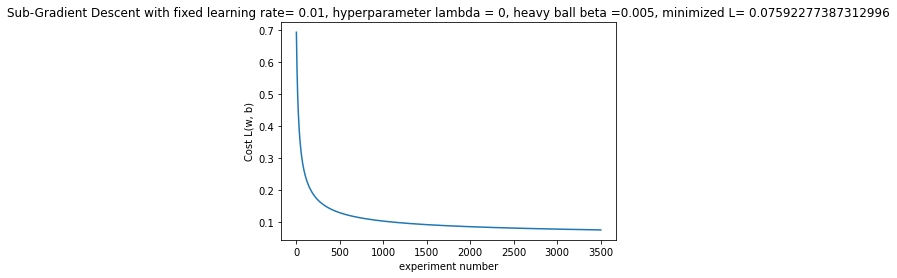

                         leant_weight
radius_mean                  0.523275
texture_mean                 0.476126
perimeter_mean               0.511322
area_mean                    0.525151
smoothness_mean              0.211291
compactness_mean             0.068150
concavity_mean               0.436629
concave points_mean          0.582714
symmetry_mean                0.098025
fractal_dimension_mean      -0.251653
radius_se                    0.521148
texture_se                  -0.018181
perimeter_se                 0.399272
area_se                      0.455787
smoothness_se                0.056640
compactness_se              -0.322636
concavity_se                -0.108046
concave points_se            0.101346
symmetry_se                 -0.178883
fractal_dimension_se        -0.340809
radius_worst                 0.652329
texture_worst                0.650188
perimeter_worst              0.603115
area_worst                   0.614346
smoothness_worst             0.491208
compactness_

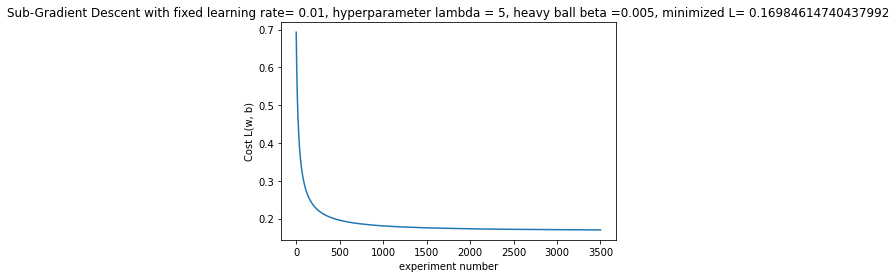

                         leant_weight
radius_mean                  0.351737
texture_mean                 0.347404
perimeter_mean               0.339391
area_mean                    0.350293
smoothness_mean              0.062294
compactness_mean             0.000093
concavity_mean               0.275352
concave points_mean          0.450619
symmetry_mean               -0.000038
fractal_dimension_mean      -0.013562
radius_se                    0.354880
texture_se                   0.000018
perimeter_se                 0.224345
area_se                      0.268665
smoothness_se                0.000076
compactness_se              -0.012542
concavity_se                 0.000057
concave points_se           -0.000040
symmetry_se                  0.000009
fractal_dimension_se        -0.166496
radius_worst                 0.504663
texture_worst                0.549247
perimeter_worst              0.461880
area_worst                   0.455730
smoothness_worst             0.390656
compactness_

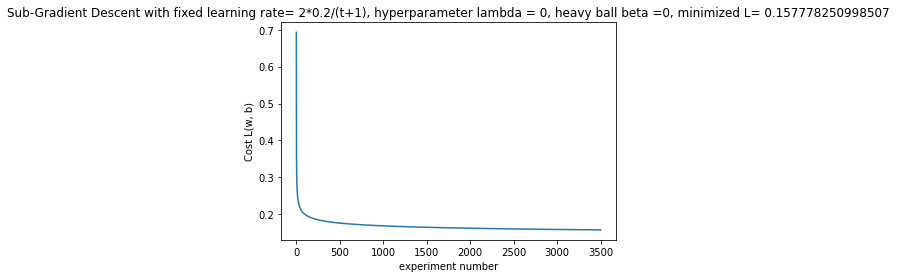

                         leant_weight
radius_mean                  0.270910
texture_mean                 0.188506
perimeter_mean               0.270765
area_mean                    0.262261
smoothness_mean              0.093833
compactness_mean             0.143570
concavity_mean               0.209463
concave points_mean          0.263211
symmetry_mean                0.066402
fractal_dimension_mean      -0.081249
radius_se                    0.203865
texture_se                  -0.009686
perimeter_se                 0.185822
area_se                      0.194678
smoothness_se               -0.030757
compactness_se              -0.002991
concavity_se                -0.019421
concave points_se            0.066584
symmetry_se                 -0.033605
fractal_dimension_se        -0.076235
radius_worst                 0.299097
texture_worst                0.224054
perimeter_worst              0.292776
area_worst                   0.278511
smoothness_worst             0.169110
compactness_

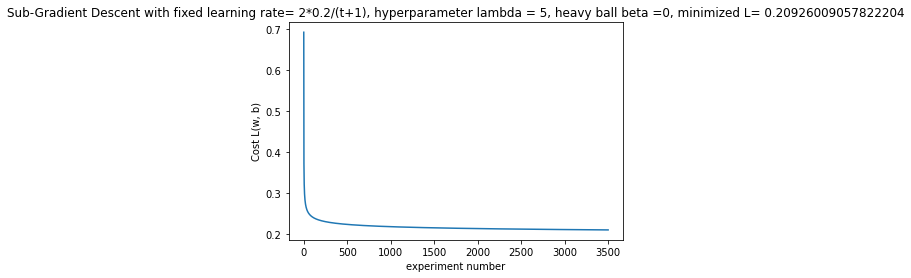

                         leant_weight
radius_mean              2.490057e-01
texture_mean             1.695328e-01
perimeter_mean           2.487882e-01
area_mean                2.422347e-01
smoothness_mean          9.467347e-02
compactness_mean         1.243241e-01
concavity_mean           1.844744e-01
concave points_mean      2.499013e-01
symmetry_mean            5.827705e-02
fractal_dimension_mean  -4.689687e-02
radius_se                1.915869e-01
texture_se              -3.014938e-07
perimeter_se             1.716470e-01
area_se                  1.806428e-01
smoothness_se            4.869752e-07
compactness_se          -8.965853e-03
concavity_se            -1.885170e-02
concave points_se        3.947837e-02
symmetry_se             -8.299916e-03
fractal_dimension_se    -5.969267e-02
radius_worst             2.808281e-01
texture_worst            2.124141e-01
perimeter_worst          2.742731e-01
area_worst               2.623212e-01
smoothness_worst         1.670917e-01
compactness_

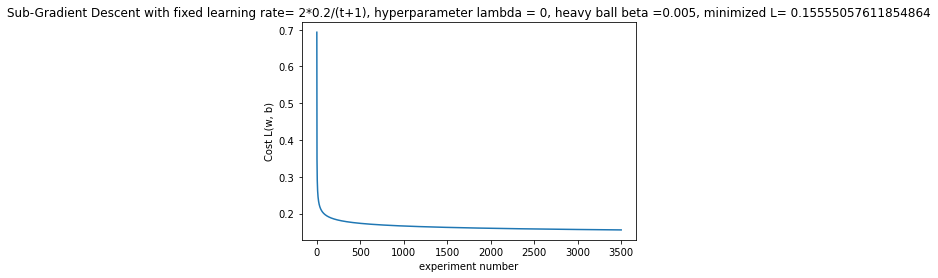

                         leant_weight
radius_mean                  0.263046
texture_mean                 0.182608
perimeter_mean               0.262957
area_mean                    0.255313
smoothness_mean              0.127452
compactness_mean             0.144107
concavity_mean               0.199570
concave points_mean          0.266023
symmetry_mean                0.107680
fractal_dimension_mean      -0.078312
radius_se                    0.209358
texture_se                  -0.004422
perimeter_se                 0.192007
area_se                      0.197632
smoothness_se               -0.018661
compactness_se              -0.008771
concavity_se                -0.033489
concave points_se            0.062348
symmetry_se                 -0.023749
fractal_dimension_se        -0.079883
radius_worst                 0.293562
texture_worst                0.215717
perimeter_worst              0.288415
area_worst                   0.275337
smoothness_worst             0.177517
compactness_

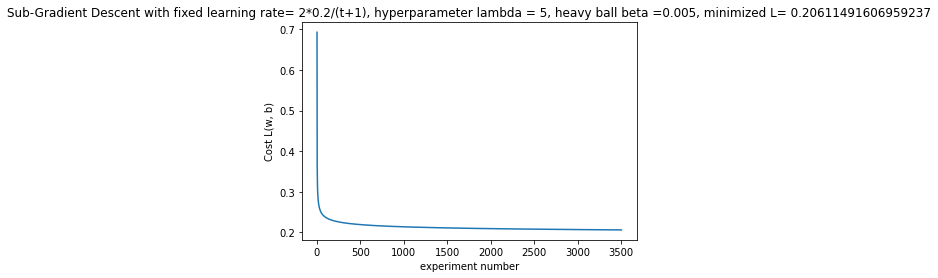

                         leant_weight
radius_mean              2.533052e-01
texture_mean             1.642786e-01
perimeter_mean           2.535520e-01
area_mean                2.451727e-01
smoothness_mean          6.810958e-02
compactness_mean         1.269798e-01
concavity_mean           1.921928e-01
concave points_mean      2.473808e-01
symmetry_mean            5.514469e-02
fractal_dimension_mean  -5.446200e-02
radius_se                1.814044e-01
texture_se               3.181000e-07
perimeter_se             1.616557e-01
area_se                  1.753868e-01
smoothness_se           -1.160101e-02
compactness_se          -1.428349e-03
concavity_se            -1.327904e-02
concave points_se        3.348904e-02
symmetry_se             -8.275403e-04
fractal_dimension_se    -3.879407e-02
radius_worst             2.858606e-01
texture_worst            2.089988e-01
perimeter_worst          2.804913e-01
area_worst               2.655677e-01
smoothness_worst         1.448345e-01
compactness_

In [ ]:
#Callers on breast cancer dataset

#breast_cancer_classification(learning_rate, beta, s, n_iter, decay_flag)
#fixed learning rate
print("***********************************WITH FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
breast_cancer_classification(0.01, 0, 0, 3500, False, 1)
print("Without heavy ball, With Lasso Regularization")
breast_cancer_classification(0.01, 0, 5, 3500, False, 1)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
breast_cancer_classification(0.01, 0.005, 0, 3500, False, 1)
print("With heavy ball, With Lasso Regularization")
breast_cancer_classification(0.01, 0.005, 5, 3500, False, 1)

#decaying learning rate
print("***********************************DECAYING FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
breast_cancer_classification(0.2, 0, 0, 3500, True, 1)
print("Without heavy ball, With Lasso Regularization")
breast_cancer_classification(0.2, 0, 5, 3500, True, 1)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
breast_cancer_classification(0.2, 0.005, 0, 3500, True, 1)
print("With heavy ball, With Lasso Regularization")
breast_cancer_classification(0.2, 0.005, 5, 3500, True, 1) 

***********************************WITH FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL************************************************************
Without heavy ball, Without Lasso Regularization
Number of examples in the training set, test set with diabetes: 228, 40
Initial loss: 0.6931471805599453


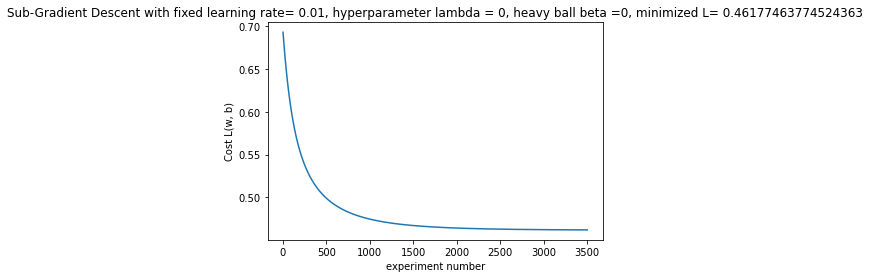

                          leant_weight
Pregnancies                   0.503332
Glucose                       1.069961
BloodPressure                -0.229341
SkinThickness                 0.063068
Insulin                      -0.115724
BMI                           0.695705
DiabetesPedigreeFunction      0.303304
Age                           0.134716
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[131.  47.]
 [ 97. 393.]]
Accuracy = 0.7844311377245509
 Precision = 0.7359550561797753
 Recall = 0.5745614035087719
 F1_score = 0.645320197044335
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[26. 10.]
 [14. 50.]]
Accuracy = 0.76
 Precision = 0.7222222222222222
 Recall = 0.65
 F1_score = 0.6842105263157895
Without heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 229, 39
Initial loss: 0.6931471805599453


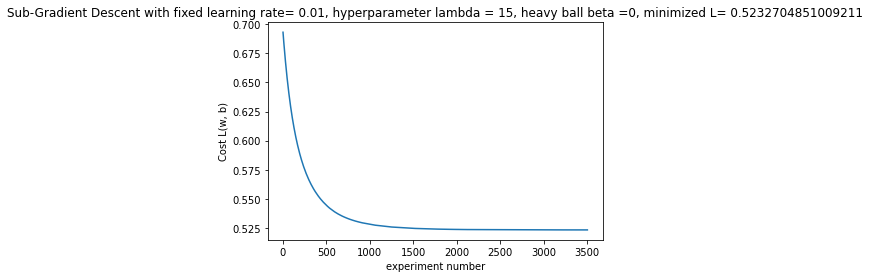

                          leant_weight
Pregnancies                   0.288758
Glucose                       0.881980
BloodPressure                -0.008344
SkinThickness                -0.000177
Insulin                      -0.000130
BMI                           0.411390
DiabetesPedigreeFunction      0.151474
Age                           0.083544
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[124.  42.]
 [105. 397.]]
Accuracy = 0.7799401197604791
 Precision = 0.7469879518072289
 Recall = 0.5414847161572053
 F1_score = 0.6278481012658229
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[17.  5.]
 [22. 56.]]
Accuracy = 0.73
 Precision = 0.7727272727272727
 Recall = 0.4358974358974359
 F1_score = 0.5573770491803278
**********************************WITH HEAVY BALL************************************************************
Heavy ball method, Without Lasso Regularization
Number of examples in the training set, te

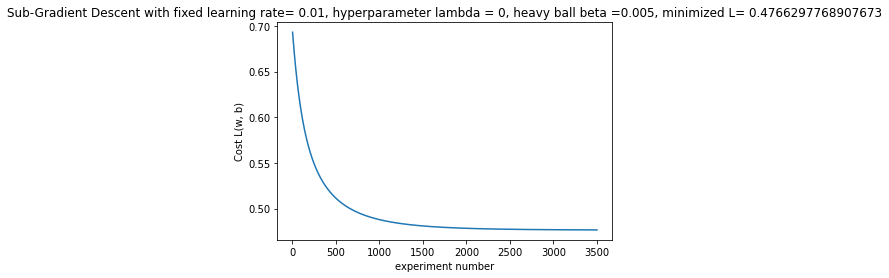

                          leant_weight
Pregnancies                   0.386986
Glucose                       1.042972
BloodPressure                -0.218427
SkinThickness                 0.023167
Insulin                      -0.129523
BMI                           0.699675
DiabetesPedigreeFunction      0.299019
Age                           0.165639
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[142.  50.]
 [ 96. 380.]]
Accuracy = 0.781437125748503
 Precision = 0.7395833333333334
 Recall = 0.5966386554621849
 F1_score = 0.6604651162790698
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[13.  5.]
 [17. 65.]]
Accuracy = 0.78
 Precision = 0.7222222222222222
 Recall = 0.43333333333333335
 F1_score = 0.5416666666666666
With heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 237, 31
Initial loss: 0.6931471805599453


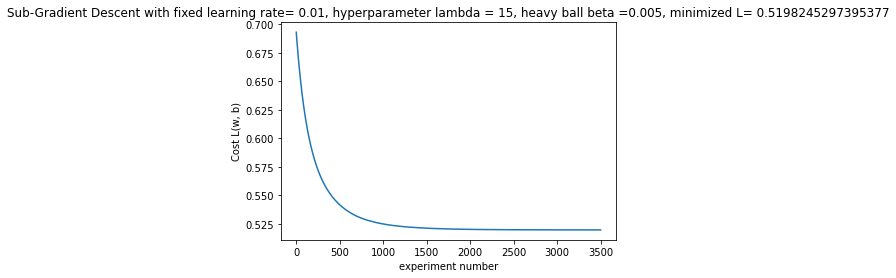

                          leant_weight
Pregnancies                   0.264868
Glucose                       0.955266
BloodPressure                -0.040604
SkinThickness                -0.000135
Insulin                      -0.000163
BMI                           0.451655
DiabetesPedigreeFunction      0.103311
Age                           0.092012
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[128.  44.]
 [109. 387.]]
Accuracy = 0.7709580838323353
 Precision = 0.7441860465116279
 Recall = 0.540084388185654
 F1_score = 0.6259168704156478
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[16.  9.]
 [15. 60.]]
Accuracy = 0.76
 Precision = 0.64
 Recall = 0.5161290322580645
 F1_score = 0.5714285714285714
***********************************DECAYING FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL*******************************************

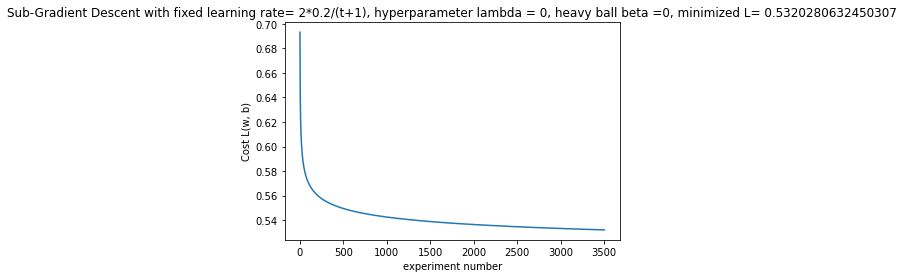

                          leant_weight
Pregnancies                   0.177936
Glucose                       0.418308
BloodPressure                -0.003150
SkinThickness                 0.034335
Insulin                       0.080118
BMI                           0.275768
DiabetesPedigreeFunction      0.139155
Age                           0.174228
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[139.  66.]
 [ 91. 372.]]
Accuracy = 0.7649700598802395
 Precision = 0.6780487804878049
 Recall = 0.6043478260869565
 F1_score = 0.639080459770115
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[22. 11.]
 [16. 51.]]
Accuracy = 0.73
 Precision = 0.6666666666666666
 Recall = 0.5789473684210527
 F1_score = 0.619718309859155
Without heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 229, 39
Initial loss: 0.6931471805599453


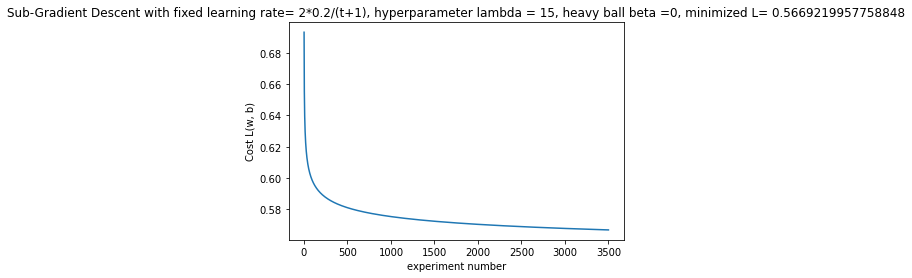

                          leant_weight
Pregnancies                   0.137756
Glucose                       0.390022
BloodPressure                -0.000157
SkinThickness                 0.000003
Insulin                       0.026747
BMI                           0.218907
DiabetesPedigreeFunction      0.094635
Age                           0.143410
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[125.  54.]
 [104. 385.]]
Accuracy = 0.7634730538922155
 Precision = 0.6983240223463687
 Recall = 0.5458515283842795
 F1_score = 0.6127450980392156
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[25. 11.]
 [14. 50.]]
Accuracy = 0.75
 Precision = 0.6944444444444444
 Recall = 0.6410256410256411
 F1_score = 0.6666666666666666
**********************************WITH HEAVY BALL************************************************************
Heavy ball method, Without Lasso Regularization
Number of examples in the training set, te

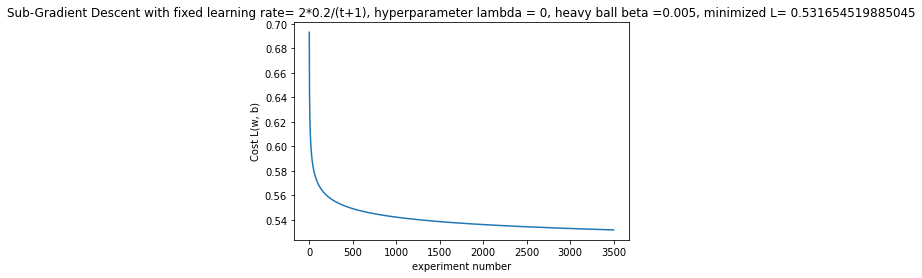

                          leant_weight
Pregnancies                   0.180707
Glucose                       0.416549
BloodPressure                 0.025453
SkinThickness                 0.018235
Insulin                       0.057287
BMI                           0.263858
DiabetesPedigreeFunction      0.155824
Age                           0.174980
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[135.  71.]
 [ 92. 370.]]
Accuracy = 0.7559880239520959
 Precision = 0.6553398058252428
 Recall = 0.5947136563876652
 F1_score = 0.6235565819861433
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[23.  5.]
 [18. 54.]]
Accuracy = 0.77
 Precision = 0.8214285714285714
 Recall = 0.5609756097560976
 F1_score = 0.6666666666666667
With heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 234, 34
Initial loss: 0.6931471805599453


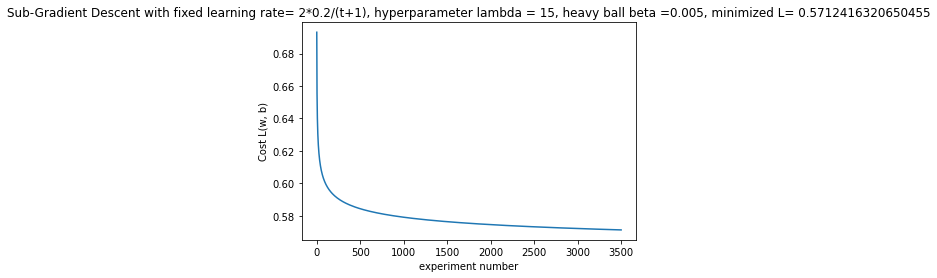

                          leant_weight
Pregnancies               1.450834e-01
Glucose                   3.841527e-01
BloodPressure             7.403168e-07
SkinThickness             8.270223e-07
Insulin                   3.241238e-02
BMI                       2.024955e-01
DiabetesPedigreeFunction  8.939155e-02
Age                       1.587472e-01
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[133.  59.]
 [101. 375.]]
Accuracy = 0.7604790419161677
 Precision = 0.6927083333333334
 Recall = 0.5683760683760684
 F1_score = 0.6244131455399061
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[21. 12.]
 [13. 54.]]
Accuracy = 0.75
 Precision = 0.6363636363636364
 Recall = 0.6176470588235294
 F1_score = 0.6268656716417911


In [ ]:
#Callers on the diabetes dataset

#Diabetes_classification(learning_rate, beta, s, n_iter, decay_flag)
#fixed learning rate
print("***********************************WITH FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
Diabetes_classification(0.01, 0, 0, 3500, False, 1)
print("Without heavy ball, With Lasso Regularization")
Diabetes_classification(0.01, 0, 15, 3500, False, 1)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
Diabetes_classification(0.01, 0.005, 0, 3500, False, 1)
print("With heavy ball, With Lasso Regularization")
Diabetes_classification(0.01, 0.005, 15, 3500, False, 1)

#decaying learning rate
print("***********************************DECAYING FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
Diabetes_classification(0.2, 0, 0, 3500, True, 1)
print("Without heavy ball, With Lasso Regularization")
Diabetes_classification(0.2, 0, 15, 3500, True, 1)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
Diabetes_classification(0.2, 0.005, 0, 3500, True, 1)
print("With heavy ball, With Lasso Regularization")
Diabetes_classification(0.2, 0.005, 15, 3500, True, 1) 

***********************************WITH FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL************************************************************
Without heavy ball, Without Lasso Regularization
Number of examples in the training set, test set with with death in heart failure: 84, 12
Initial loss: 0.6931471805599454


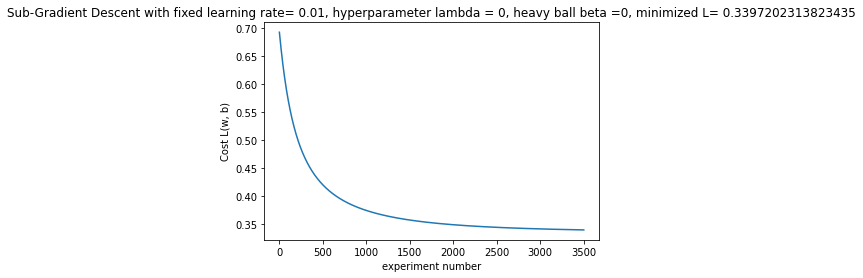

                          leant_weight
age                           0.578399
anaemia                      -0.104596
creatinine_phosphokinase      0.223121
diabetes                      0.039509
ejection_fraction            -0.777391
high_blood_pressure          -0.066191
platelets                    -0.148763
serum_creatinine              0.635139
serum_sodium                 -0.216163
sex                          -0.234289
smoking                      -0.066435
time                         -1.680754
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 64.  12.]
 [ 20. 153.]]
Accuracy = 0.8714859437751004
 Precision = 0.8421052631578947
 Recall = 0.7619047619047619
 F1_score = 0.8
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 7.  6.]
 [ 5. 32.]]
Accuracy = 0.78
 Precision = 0.5384615384615384
 Recall = 0.5833333333333334
 F1_score = 0.5599999999999999
Without heavy ball, With Lasso Regularization
Number of exa

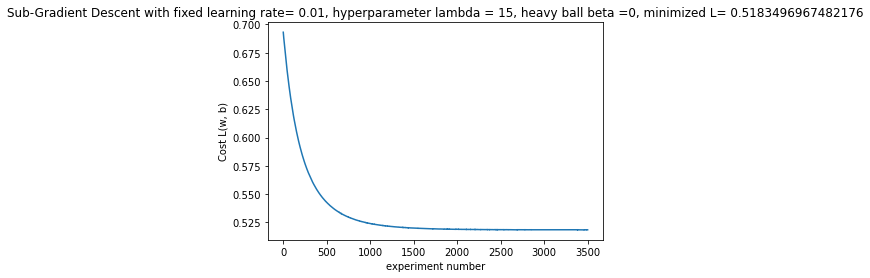

                          leant_weight
age                           0.043940
anaemia                       0.000501
creatinine_phosphokinase      0.000493
diabetes                      0.000263
ejection_fraction            -0.366129
high_blood_pressure           0.000657
platelets                    -0.000123
serum_creatinine              0.287978
serum_sodium                 -0.000532
sex                           0.000181
smoking                       0.000464
time                         -0.857960
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 40.   5.]
 [ 35. 169.]]
Accuracy = 0.8393574297188755
 Precision = 0.8888888888888888
 Recall = 0.5333333333333333
 F1_score = 0.6666666666666667
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[11.  1.]
 [10. 28.]]
Accuracy = 0.78
 Precision = 0.9166666666666666
 Recall = 0.5238095238095238
 F1_score = 0.6666666666666667
**********************************WITH HEAVY

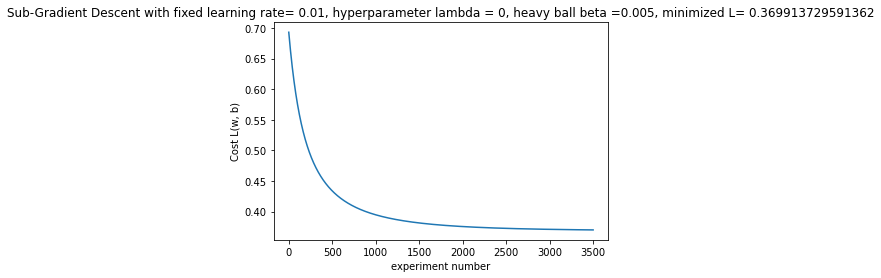

                          leant_weight
age                           0.573834
anaemia                      -0.028407
creatinine_phosphokinase      0.225821
diabetes                      0.033254
ejection_fraction            -0.744944
high_blood_pressure          -0.049994
platelets                    -0.075880
serum_creatinine              0.631247
serum_sodium                 -0.410067
sex                          -0.163173
smoking                      -0.036626
time                         -1.494018
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 64.  14.]
 [ 24. 147.]]
Accuracy = 0.8473895582329317
 Precision = 0.8205128205128205
 Recall = 0.7272727272727273
 F1_score = 0.7710843373493976
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 7.  7.]
 [ 1. 35.]]
Accuracy = 0.84
 Precision = 0.5
 Recall = 0.875
 F1_score = 0.6363636363636364
With heavy ball, With Lasso Regularization
Number of examples in the tra

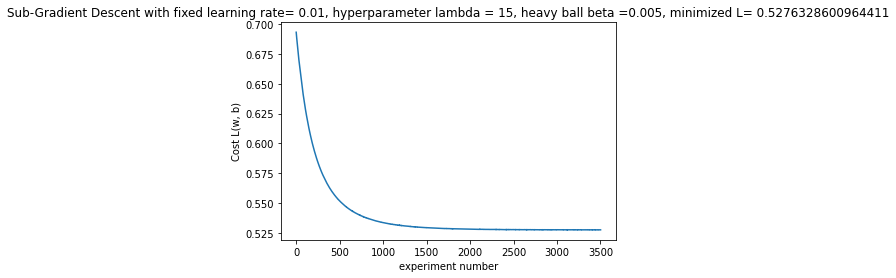

                          leant_weight
age                           0.094959
anaemia                      -0.000474
creatinine_phosphokinase      0.000396
diabetes                     -0.000368
ejection_fraction            -0.222393
high_blood_pressure           0.000022
platelets                    -0.000609
serum_creatinine              0.204914
serum_sodium                 -0.104336
sex                          -0.000119
smoking                      -0.000241
time                         -0.998966
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 58.   7.]
 [ 26. 158.]]
Accuracy = 0.8674698795180723
 Precision = 0.8923076923076924
 Recall = 0.6904761904761905
 F1_score = 0.7785234899328859
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 6.  1.]
 [ 6. 37.]]
Accuracy = 0.86
 Precision = 0.8571428571428571
 Recall = 0.5
 F1_score = 0.631578947368421
***********************************DECAYING FIXED STEP SIZE*

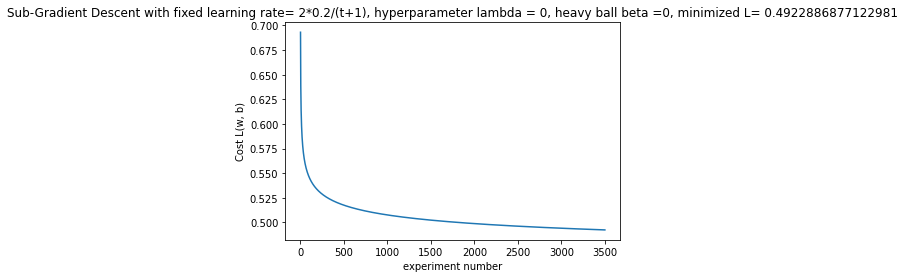

                          leant_weight
age                           0.190900
anaemia                       0.036748
creatinine_phosphokinase      0.024392
diabetes                     -0.018374
ejection_fraction            -0.253848
high_blood_pressure           0.070162
platelets                    -0.006124
serum_creatinine              0.259417
serum_sodium                 -0.157202
sex                          -0.003176
smoking                       0.014128
time                         -0.494921
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 63.  19.]
 [ 20. 147.]]
Accuracy = 0.8433734939759037
 Precision = 0.7682926829268293
 Recall = 0.7590361445783133
 F1_score = 0.7636363636363638
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[10.  2.]
 [ 3. 35.]]
Accuracy = 0.9
 Precision = 0.8333333333333334
 Recall = 0.7692307692307693
 F1_score = 0.8
Without heavy ball, With Lasso Regularization
Number of exam

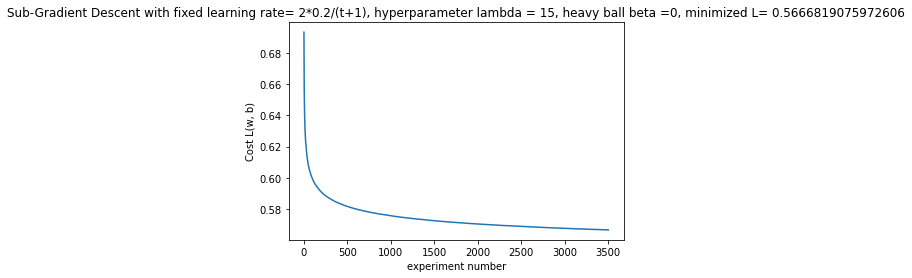

                          leant_weight
age                       1.232706e-01
anaemia                  -2.956373e-06
creatinine_phosphokinase  5.200845e-06
diabetes                  2.669858e-06
ejection_fraction        -7.687216e-02
high_blood_pressure       7.024583e-06
platelets                -1.584518e-07
serum_creatinine          1.453781e-01
serum_sodium             -5.391395e-02
sex                      -3.818951e-06
smoking                   9.459829e-08
time                     -4.097806e-01
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 51.  11.]
 [ 28. 159.]]
Accuracy = 0.8433734939759037
 Precision = 0.8225806451612904
 Recall = 0.6455696202531646
 F1_score = 0.723404255319149
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 9.  0.]
 [ 8. 33.]]
Accuracy = 0.84
 Precision = 1.0
 Recall = 0.5294117647058824
 F1_score = 0.6923076923076924
**********************************WITH HEAVY BALL***********

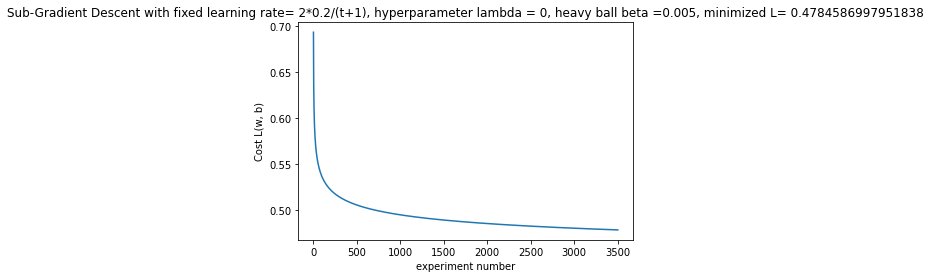

                          leant_weight
age                           0.228382
anaemia                       0.017180
creatinine_phosphokinase      0.118475
diabetes                     -0.004600
ejection_fraction            -0.239772
high_blood_pressure           0.020686
platelets                    -0.048174
serum_creatinine              0.284791
serum_sodium                 -0.152639
sex                          -0.012350
smoking                       0.026770
time                         -0.510908
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 62.  20.]
 [ 22. 145.]]
Accuracy = 0.8313253012048193
 Precision = 0.7560975609756098
 Recall = 0.7380952380952381
 F1_score = 0.746987951807229
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 8.  3.]
 [ 4. 35.]]
Accuracy = 0.86
 Precision = 0.7272727272727273
 Recall = 0.6666666666666666
 F1_score = 0.6956521739130435
With heavy ball, With Lasso Regularization
Nu

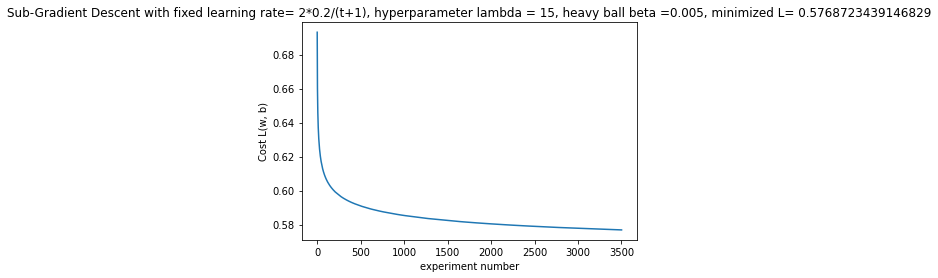

                          leant_weight
age                       9.827242e-02
anaemia                  -6.969318e-07
creatinine_phosphokinase  9.495184e-06
diabetes                 -4.841514e-06
ejection_fraction        -1.238978e-01
high_blood_pressure       5.232799e-06
platelets                -3.427479e-06
serum_creatinine          1.828744e-01
serum_sodium             -4.191483e-02
sex                       5.577976e-06
smoking                   2.644777e-06
time                     -3.863806e-01
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 52.  11.]
 [ 30. 156.]]
Accuracy = 0.8353413654618473
 Precision = 0.8253968253968254
 Recall = 0.6341463414634146
 F1_score = 0.7172413793103449
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[10.  3.]
 [ 4. 33.]]
Accuracy = 0.86
 Precision = 0.7692307692307693
 Recall = 0.7142857142857143
 F1_score = 0.7407407407407408


In [ ]:
#Callers on the heart failure dataset

#heart_failure_classification(learning_rate, beta, s, n_iter, decay_flag)
#fixed learning rate
print("***********************************WITH FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
heart_failure_classification(0.01, 0, 0, 3500, False, 1)
print("Without heavy ball, With Lasso Regularization")
heart_failure_classification(0.01, 0, 15, 3500, False, 1)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
heart_failure_classification(0.01, 0.005, 0, 3500, False, 1)
print("With heavy ball, With Lasso Regularization")
heart_failure_classification(0.01, 0.005, 15, 3500, False, 1)

#decaying learning rate
print("***********************************DECAYING FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
heart_failure_classification(0.2, 0, 0, 3500, True, 1)
print("Without heavy ball, With Lasso Regularization")
heart_failure_classification(0.2, 0, 15, 3500, True, 1)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
heart_failure_classification(0.2, 0.005, 0, 3500, True, 1)
print("With heavy ball, With Lasso Regularization")
heart_failure_classification(0.2, 0.005, 15, 3500, True, 1) 


In [ ]:
##########################################Mirror descent code############################################################  
# The same code can be reused for heavy-ball subgradient method and normal subgradient method, by setting beta (beta=0 in the normal case) 
def mirrorDescent(X, y, w0, b0, s, learning_rate, beta, n_iter, decay_flag):
  #initializing the initial weight
  #heavy ball tuning hyperparameter beta
  w_t = w0
  b_t = b0
  #stores the loss over iterations
  loss = []
  #init_loss
  print("Initial loss: "+str(cost(X, y, w_t, b_t, s)))
  loss.append(cost(X, y, w_t, b_t, s))
  
  w_t_1 = w_t
  b_t_1 = b_t

  #w_-1 = w_0, 1st step: no heavy ball (convention)
  dw_t, db_t =  subgradients_lasso_logistic(X, y, w_t, b_t, s)
  w_t = w_t*np.exp(-1*learning_rate*dw_t)
  b_t = b_t*np.exp(-1*learning_rate*db_t)
  
  loss.append(cost(X, y, w_t, b_t, s))
  
  for i in range(2, 1+n_iter):
    lr = 0
    if decay_flag == False:
      lr = learning_rate
    else:
      #learning rate is a measure of 1/u
      lr = 2*learning_rate/(i+1)

    temp_w_t = w_t
    temp_b_t = b_t

    dw_t, db_t =  subgradients_lasso_logistic(X, y, w_t, b_t, s)
    
    w_t = w_t*np.exp(-1*lr*dw_t) + beta*(w_t - w_t_1)
    b_t = b_t*np.exp(-1*lr*db_t) + beta*(b_t - b_t_1)
    
    w_t_1 = temp_w_t
    b_t_1 = temp_b_t
    
    loss.append(cost(X, y, w_t, b_t, s))
    #if i%100 == 0:
    #  print("Loss after "+str(i)+" iteration: "+str(cost(X, y, w_t, b_t, s)))
  if decay_flag == False:
    plot_curve(loss, "experiment number", "Cost L(w, b)", "Mirror Descent with fixed learning rate= "+str(learning_rate)+", hyperparameter lambda = "+str(s)+", heavy ball beta ="+str(beta)+", minimized L= "+str(cost(X, y, w_t, b_t, s)))
  else:
    plot_curve(loss, "experiment number", "Cost L(w, b)", "Mirror Descent with fixed learning rate= 2*"+str(learning_rate)+"/(t+1), hyperparameter lambda = "+str(s)+", heavy ball beta ="+str(beta)+", minimized L= "+str(cost(X, y, w_t, b_t, s)))
  return w_t, b_t

#takes the training data and return learnt weights
def fit_logistic_regression_mirrorDescent(X_train, y_train, s, learning_rate, beta, n_iter, decay_flag):
  w0 = np.ones((1, X_train.shape[0]))/(X_train.shape[0]+1)      #initializing to 1/(n+1)
  b0 = 1/(X_train.shape[0]+1)
  w, b = mirrorDescent(X_train, y_train, w0, b0, s, learning_rate, beta, n_iter, decay_flag)
  return w, b
##########################################################################################################################################

***********************************WITH FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL************************************************************
Without heavy ball, Without Lasso Regularization
Number of Malignent examples in the training set, test set: 190, 22
Initial loss: 0.523729650643427


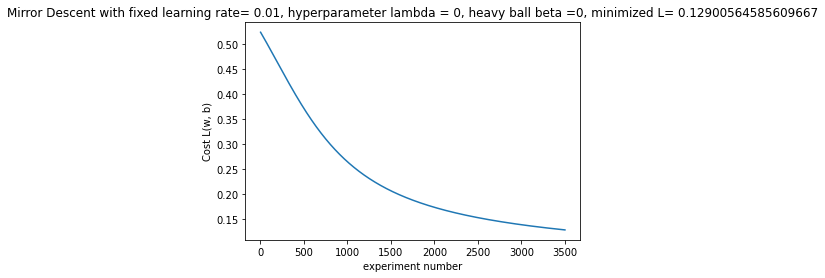

                         leant_weight
radius_mean                  0.405781
texture_mean                 0.225204
perimeter_mean               0.398802
area_mean                    0.379718
smoothness_mean              0.075156
compactness_mean             0.092381
concavity_mean               0.180424
concave points_mean          0.352916
symmetry_mean                0.056621
fractal_dimension_mean       0.010411
radius_se                    0.210134
texture_se                   0.026039
perimeter_se                 0.180469
area_se                      0.202585
smoothness_se                0.020982
compactness_se               0.018656
concavity_se                 0.014458
concave points_se            0.039462
symmetry_se                  0.017737
fractal_dimension_se         0.007845
radius_worst                 0.573540
texture_worst                0.340945
perimeter_worst              0.539626
area_worst                   0.482973
smoothness_worst             0.181360
compactness_

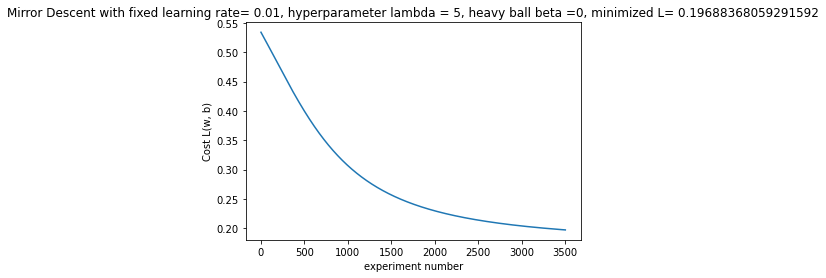

                         leant_weight
radius_mean                  0.349780
texture_mean                 0.188318
perimeter_mean               0.344868
area_mean                    0.328538
smoothness_mean              0.066691
compactness_mean             0.076627
concavity_mean               0.157576
concave points_mean          0.329901
symmetry_mean                0.054791
fractal_dimension_mean       0.007458
radius_se                    0.178706
texture_se                   0.019225
perimeter_se                 0.146358
area_se                      0.169079
smoothness_se                0.014583
compactness_se               0.012585
concavity_se                 0.010744
concave points_se            0.029048
symmetry_se                  0.011210
fractal_dimension_se         0.005592
radius_worst                 0.510995
texture_worst                0.286891
perimeter_worst              0.471461
area_worst                   0.425802
smoothness_worst             0.160792
compactness_

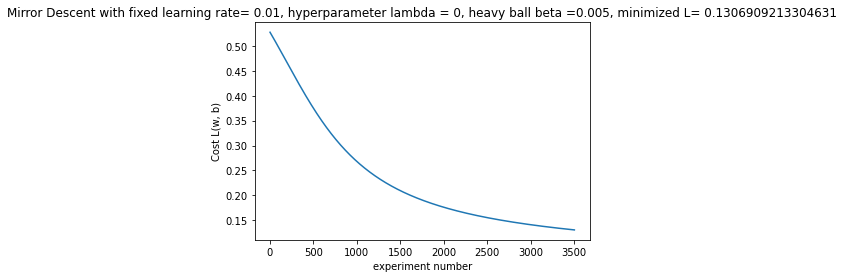

                         leant_weight
radius_mean                  0.415396
texture_mean                 0.228947
perimeter_mean               0.406782
area_mean                    0.383628
smoothness_mean              0.077109
compactness_mean             0.092597
concavity_mean               0.181364
concave points_mean          0.377253
symmetry_mean                0.063061
fractal_dimension_mean       0.009995
radius_se                    0.201091
texture_se                   0.020999
perimeter_se                 0.165988
area_se                      0.198989
smoothness_se                0.016091
compactness_se               0.018007
concavity_se                 0.014327
concave points_se            0.036960
symmetry_se                  0.015429
fractal_dimension_se         0.007734
radius_worst                 0.579391
texture_worst                0.337869
perimeter_worst              0.538780
area_worst                   0.481844
smoothness_worst             0.169600
compactness_

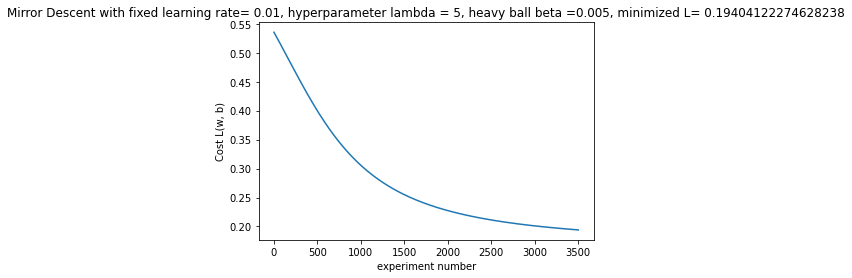

                         leant_weight
radius_mean                  0.359913
texture_mean                 0.204393
perimeter_mean               0.354475
area_mean                    0.337117
smoothness_mean              0.058577
compactness_mean             0.080177
concavity_mean               0.159433
concave points_mean          0.319518
symmetry_mean                0.051049
fractal_dimension_mean       0.007426
radius_se                    0.164252
texture_se                   0.016921
perimeter_se                 0.137273
area_se                      0.166755
smoothness_se                0.013926
compactness_se               0.013994
concavity_se                 0.011403
concave points_se            0.029011
symmetry_se                  0.013779
fractal_dimension_se         0.005729
radius_worst                 0.516588
texture_worst                0.312358
perimeter_worst              0.479159
area_worst                   0.433179
smoothness_worst             0.160583
compactness_

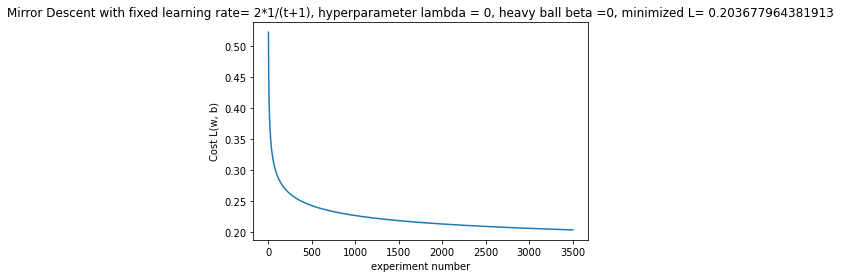

                         leant_weight
radius_mean                  0.243656
texture_mean                 0.123851
perimeter_mean               0.242944
area_mean                    0.225415
smoothness_mean              0.062947
compactness_mean             0.097329
concavity_mean               0.141566
concave points_mean          0.217227
symmetry_mean                0.052761
fractal_dimension_mean       0.016853
radius_se                    0.129073
texture_se                   0.024809
perimeter_se                 0.120185
area_se                      0.126722
smoothness_se                0.022562
compactness_se               0.034009
concavity_se                 0.029099
concave points_se            0.054332
symmetry_se                  0.021171
fractal_dimension_se         0.017962
radius_worst                 0.289440
texture_worst                0.148243
perimeter_worst              0.280800
area_worst                   0.248631
smoothness_worst             0.106435
compactness_

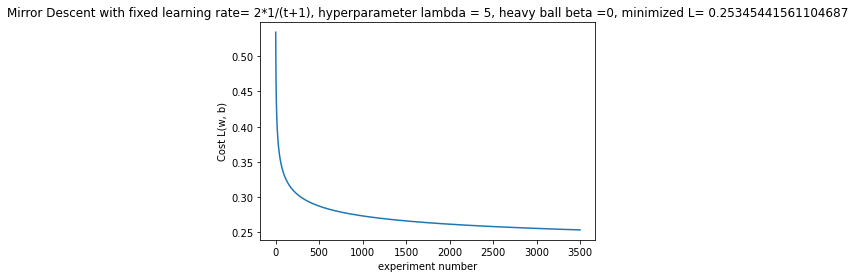

                         leant_weight
radius_mean                  0.224519
texture_mean                 0.114550
perimeter_mean               0.223978
area_mean                    0.205183
smoothness_mean              0.057674
compactness_mean             0.087710
concavity_mean               0.130695
concave points_mean          0.200720
symmetry_mean                0.052500
fractal_dimension_mean       0.015163
radius_se                    0.117403
texture_se                   0.020064
perimeter_se                 0.107486
area_se                      0.113203
smoothness_se                0.016491
compactness_se               0.026869
concavity_se                 0.023668
concave points_se            0.043397
symmetry_se                  0.018824
fractal_dimension_se         0.015353
radius_worst                 0.273632
texture_worst                0.140846
perimeter_worst              0.264910
area_worst                   0.230318
smoothness_worst             0.092701
compactness_

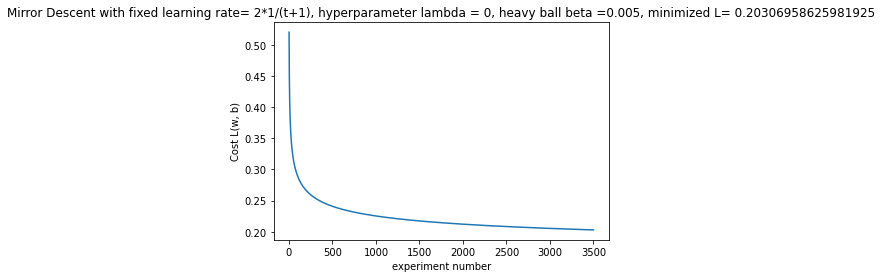

                         leant_weight
radius_mean                  0.233439
texture_mean                 0.117607
perimeter_mean               0.232901
area_mean                    0.216147
smoothness_mean              0.064210
compactness_mean             0.098019
concavity_mean               0.150085
concave points_mean          0.219901
symmetry_mean                0.057197
fractal_dimension_mean       0.017579
radius_se                    0.130634
texture_se                   0.024614
perimeter_se                 0.118217
area_se                      0.126420
smoothness_se                0.020636
compactness_se               0.033778
concavity_se                 0.032442
concave points_se            0.053122
symmetry_se                  0.022721
fractal_dimension_se         0.017171
radius_worst                 0.284627
texture_worst                0.145789
perimeter_worst              0.275051
area_worst                   0.243618
smoothness_worst             0.104543
compactness_

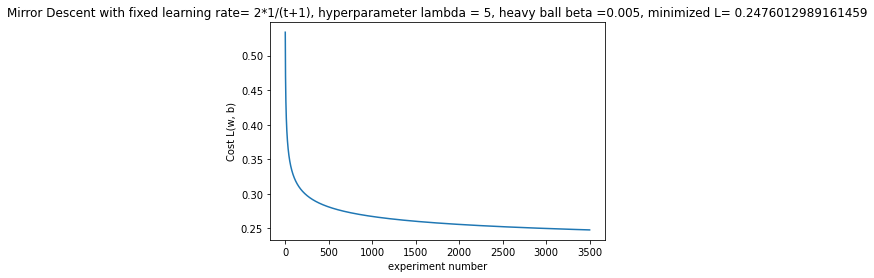

                         leant_weight
radius_mean                  0.227546
texture_mean                 0.104777
perimeter_mean               0.226630
area_mean                    0.208965
smoothness_mean              0.055974
compactness_mean             0.087205
concavity_mean               0.135260
concave points_mean          0.206837
symmetry_mean                0.054970
fractal_dimension_mean       0.014051
radius_se                    0.120355
texture_se                   0.021334
perimeter_se                 0.107763
area_se                      0.115678
smoothness_se                0.018788
compactness_se               0.028856
concavity_se                 0.024830
concave points_se            0.047908
symmetry_se                  0.018838
fractal_dimension_se         0.014815
radius_worst                 0.278264
texture_worst                0.132987
perimeter_worst              0.265957
area_worst                   0.235223
smoothness_worst             0.098956
compactness_

In [ ]:
#Callers on breast cancer dataset

#breast_cancer_classification(learning_rate, beta, s, n_iter, decay_flag)
#fixed learning rate
print("***********************************WITH FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
breast_cancer_classification(0.01, 0, 0, 3500, False, 2)
print("Without heavy ball, With Lasso Regularization")
breast_cancer_classification(0.01, 0, 5, 3500, False, 2)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
breast_cancer_classification(0.01, 0.005, 0, 3500, False, 2)
print("With heavy ball, With Lasso Regularization")
breast_cancer_classification(0.01, 0.005, 5, 3500, False, 2)

#decaying learning rate
print("***********************************DECAYING FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
breast_cancer_classification(1, 0, 0, 3500, True, 2)
print("Without heavy ball, With Lasso Regularization")
breast_cancer_classification(1, 0, 5, 3500, True, 2)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
breast_cancer_classification(1, 0.005, 0, 3500, True, 2)
print("With heavy ball, With Lasso Regularization")
breast_cancer_classification(1, 0.005, 5, 3500, True, 2) 

***********************************WITH FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL************************************************************
Without heavy ball, Without Lasso Regularization
Number of examples in the training set, test set with diabetes: 239, 29
Initial loss: 0.6417376565524466


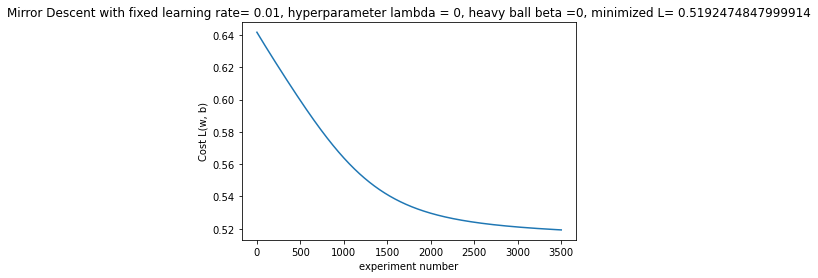

                          leant_weight
Pregnancies                   0.320462
Glucose                       1.031019
BloodPressure                 0.025039
SkinThickness                 0.062486
Insulin                       0.059519
BMI                           0.416014
DiabetesPedigreeFunction      0.243413
Age                           0.186190
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[191. 122.]
 [ 48. 307.]]
Accuracy = 0.7455089820359282
 Precision = 0.610223642172524
 Recall = 0.799163179916318
 F1_score = 0.6920289855072465
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[15. 23.]
 [14. 48.]]
Accuracy = 0.63
 Precision = 0.39473684210526316
 Recall = 0.5172413793103449
 F1_score = 0.44776119402985076
Without heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 245, 23
Initial loss: 0.661549317760325


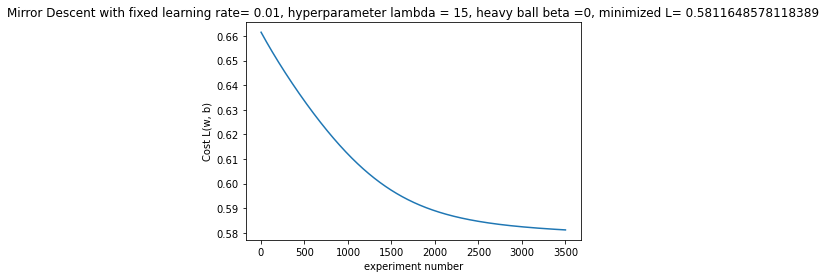

                          leant_weight
Pregnancies                   0.247514
Glucose                       0.785524
BloodPressure                 0.022079
SkinThickness                 0.035006
Insulin                       0.041353
BMI                           0.222347
DiabetesPedigreeFunction      0.138439
Age                           0.230754
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[194. 121.]
 [ 51. 302.]]
Accuracy = 0.7425149700598802
 Precision = 0.6158730158730159
 Recall = 0.7918367346938775
 F1_score = 0.6928571428571428
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[14. 27.]
 [ 9. 50.]]
Accuracy = 0.64
 Precision = 0.34146341463414637
 Recall = 0.6086956521739131
 F1_score = 0.4375
**********************************WITH HEAVY BALL************************************************************
Heavy ball method, Without Lasso Regularization
Number of examples in the training set, test set with

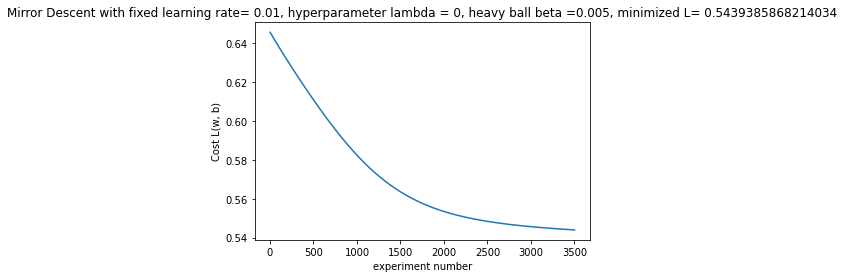

                          leant_weight
Pregnancies                   0.261467
Glucose                       0.902250
BloodPressure                 0.036593
SkinThickness                 0.063295
Insulin                       0.057735
BMI                           0.420618
DiabetesPedigreeFunction      0.243210
Age                           0.181450
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[186. 129.]
 [ 56. 297.]]
Accuracy = 0.7230538922155688
 Precision = 0.5904761904761905
 Recall = 0.768595041322314
 F1_score = 0.6678635547576302
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[20. 18.]
 [ 6. 56.]]
Accuracy = 0.76
 Precision = 0.5263157894736842
 Recall = 0.7692307692307693
 F1_score = 0.625
With heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 227, 41
Initial loss: 0.6718577034473607


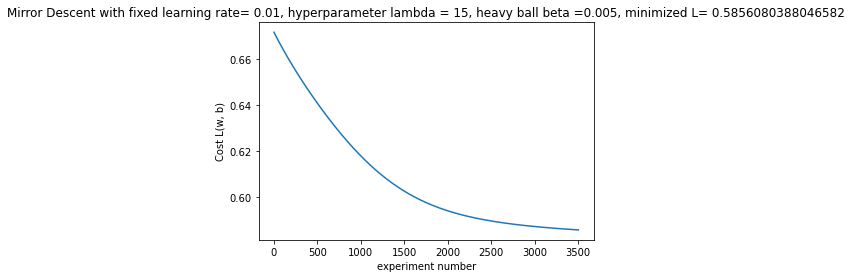

                          leant_weight
Pregnancies                   0.186846
Glucose                       0.797241
BloodPressure                 0.012794
SkinThickness                 0.025855
Insulin                       0.039774
BMI                           0.311673
DiabetesPedigreeFunction      0.153773
Age                           0.112926
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[175. 122.]
 [ 52. 319.]]
Accuracy = 0.7395209580838323
 Precision = 0.5892255892255892
 Recall = 0.7709251101321586
 F1_score = 0.66793893129771
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[29. 20.]
 [12. 39.]]
Accuracy = 0.68
 Precision = 0.5918367346938775
 Recall = 0.7073170731707317
 F1_score = 0.6444444444444445
***********************************DECAYING FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL******************************

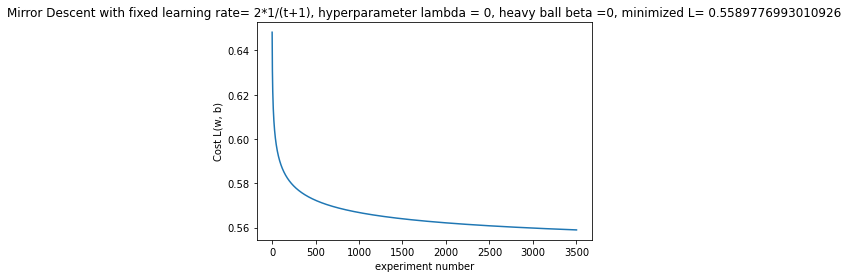

                          leant_weight
Pregnancies                   0.201451
Glucose                       0.628413
BloodPressure                 0.066540
SkinThickness                 0.082372
Insulin                       0.100507
BMI                           0.257321
DiabetesPedigreeFunction      0.158305
Age                           0.185021
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[177. 130.]
 [ 58. 303.]]
Accuracy = 0.718562874251497
 Precision = 0.5765472312703583
 Recall = 0.7531914893617021
 F1_score = 0.6531365313653136
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[25. 20.]
 [ 8. 47.]]
Accuracy = 0.72
 Precision = 0.5555555555555556
 Recall = 0.7575757575757576
 F1_score = 0.6410256410256411
Without heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 231, 37
Initial loss: 0.6670304749646164


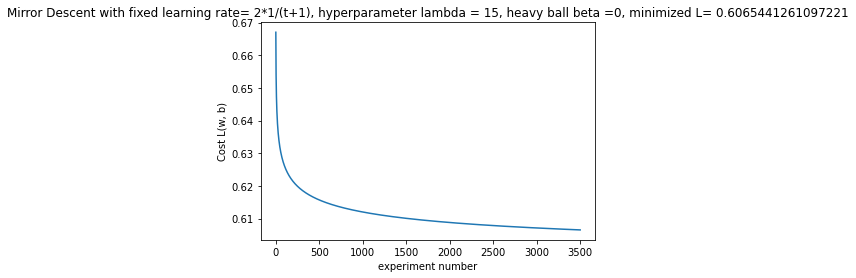

                          leant_weight
Pregnancies                   0.165315
Glucose                       0.467377
BloodPressure                 0.053464
SkinThickness                 0.069399
Insulin                       0.084914
BMI                           0.213975
DiabetesPedigreeFunction      0.142890
Age                           0.143937
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[175. 137.]
 [ 56. 300.]]
Accuracy = 0.7110778443113772
 Precision = 0.5608974358974359
 Recall = 0.7575757575757576
 F1_score = 0.6445672191528545
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[27. 14.]
 [10. 49.]]
Accuracy = 0.76
 Precision = 0.6585365853658537
 Recall = 0.7297297297297297
 F1_score = 0.6923076923076923
**********************************WITH HEAVY BALL************************************************************
Heavy ball method, Without Lasso Regularization
Number of examples in the training set, te

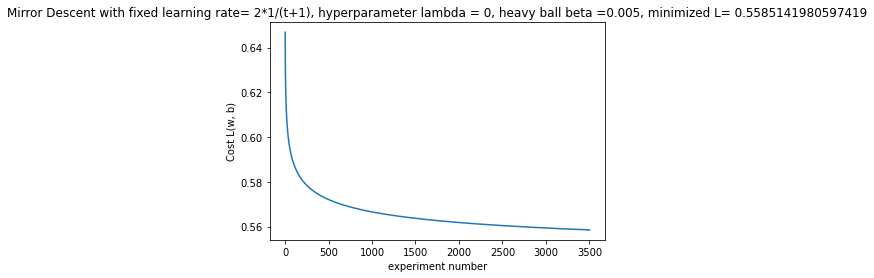

                          leant_weight
Pregnancies                   0.203768
Glucose                       0.582940
BloodPressure                 0.061188
SkinThickness                 0.079381
Insulin                       0.114771
BMI                           0.293931
DiabetesPedigreeFunction      0.188275
Age                           0.186904
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[173. 133.]
 [ 57. 305.]]
Accuracy = 0.7155688622754491
 Precision = 0.565359477124183
 Recall = 0.7521739130434782
 F1_score = 0.6455223880597014
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[30. 18.]
 [ 8. 44.]]
Accuracy = 0.74
 Precision = 0.625
 Recall = 0.7894736842105263
 F1_score = 0.6976744186046512
With heavy ball, With Lasso Regularization
Number of examples in the training set, test set with diabetes: 235, 33
Initial loss: 0.6698618883285178


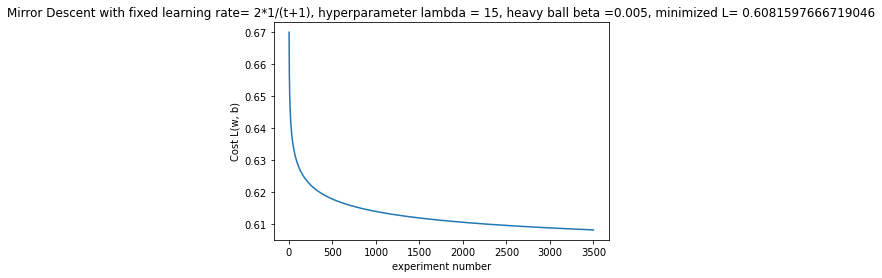

                          leant_weight
Pregnancies                   0.152207
Glucose                       0.477821
BloodPressure                 0.053576
SkinThickness                 0.063010
Insulin                       0.073928
BMI                           0.217005
DiabetesPedigreeFunction      0.129998
Age                           0.154408
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[179. 134.]
 [ 56. 299.]]
Accuracy = 0.7155688622754491
 Precision = 0.5718849840255591
 Recall = 0.7617021276595745
 F1_score = 0.6532846715328466
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[26. 18.]
 [ 7. 49.]]
Accuracy = 0.75
 Precision = 0.5909090909090909
 Recall = 0.7878787878787878
 F1_score = 0.6753246753246752


In [ ]:
#Callers on the diabetes dataset

#Diabetes_classification(learning_rate, beta, s, n_iter, decay_flag)
#fixed learning rate
print("***********************************WITH FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
Diabetes_classification(0.01, 0, 0, 3500, False, 2)
print("Without heavy ball, With Lasso Regularization")
Diabetes_classification(0.01, 0, 15, 3500, False, 2)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
Diabetes_classification(0.01, 0.005, 0, 3500, False, 2)
print("With heavy ball, With Lasso Regularization")
Diabetes_classification(0.01, 0.005, 15, 3500, False, 2)

#decaying learning rate
print("***********************************DECAYING FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
Diabetes_classification(1, 0, 0, 3500, True, 2)
print("Without heavy ball, With Lasso Regularization")
Diabetes_classification(1, 0, 15, 3500, True, 2)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
Diabetes_classification(1, 0.005, 0, 3500, True, 2)
print("With heavy ball, With Lasso Regularization")
Diabetes_classification(1, 0.005, 15, 3500, True, 2) 

***********************************WITH FIXED STEP SIZE************************************************************
**********************************WITHOUT HEAVY BALL************************************************************
Without heavy ball, Without Lasso Regularization
Number of examples in the training set, test set with with death in heart failure: 80, 16
Initial loss: 0.7301347828255166


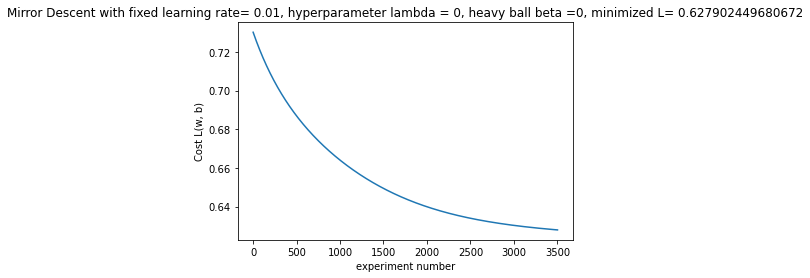

                          leant_weight
age                           0.431817
anaemia                       0.106419
creatinine_phosphokinase      0.111294
diabetes                      0.038489
ejection_fraction             0.000543
high_blood_pressure           0.149455
platelets                     0.017768
serum_creatinine              0.537541
serum_sodium                  0.005235
sex                           0.049001
smoking                       0.027719
time                          0.000042
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 50.  54.]
 [ 30. 115.]]
Accuracy = 0.6626506024096386
 Precision = 0.4807692307692308
 Recall = 0.625
 F1_score = 0.5434782608695652
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[11. 13.]
 [ 5. 21.]]
Accuracy = 0.64
 Precision = 0.4583333333333333
 Recall = 0.6875
 F1_score = 0.5499999999999999
Without heavy ball, With Lasso Regularization
Number of examples in t

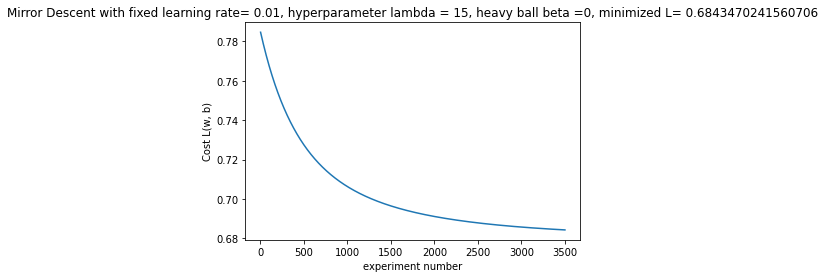

                          leant_weight
age                           0.148978
anaemia                       0.029496
creatinine_phosphokinase      0.011327
diabetes                      0.016743
ejection_fraction             0.000082
high_blood_pressure           0.017603
platelets                     0.002993
serum_creatinine              0.210083
serum_sodium                  0.000523
sex                           0.003792
smoking                       0.005536
time                          0.000002
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 53.  55.]
 [ 29. 112.]]
Accuracy = 0.6626506024096386
 Precision = 0.49074074074074076
 Recall = 0.6463414634146342
 F1_score = 0.5578947368421053
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 8. 10.]
 [ 6. 26.]]
Accuracy = 0.68
 Precision = 0.4444444444444444
 Recall = 0.5714285714285714
 F1_score = 0.5
**********************************WITH HEAVY BALL*********

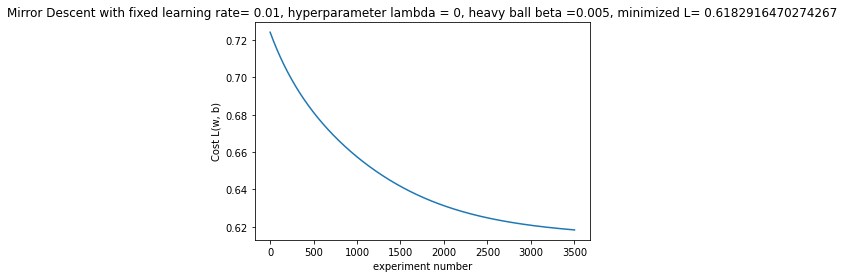

                          leant_weight
age                           0.426315
anaemia                       0.122586
creatinine_phosphokinase      0.114382
diabetes                      0.041802
ejection_fraction             0.001504
high_blood_pressure           0.201604
platelets                     0.034386
serum_creatinine              0.601372
serum_sodium                  0.006035
sex                           0.022722
smoking                       0.037403
time                          0.000034
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 52.  50.]
 [ 29. 118.]]
Accuracy = 0.6827309236947792
 Precision = 0.5098039215686274
 Recall = 0.6419753086419753
 F1_score = 0.5683060109289617
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[10. 12.]
 [ 5. 23.]]
Accuracy = 0.66
 Precision = 0.45454545454545453
 Recall = 0.6666666666666666
 F1_score = 0.5405405405405405
With heavy ball, With Lasso Regularization


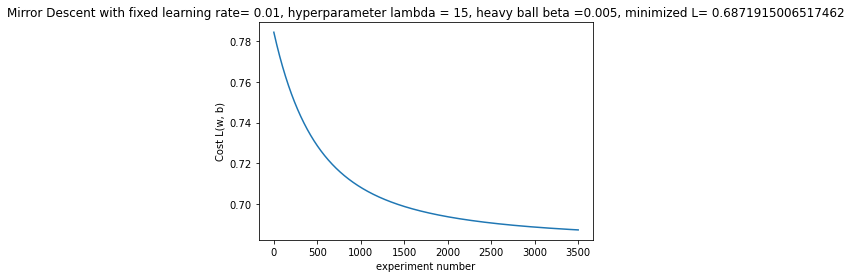

                          leant_weight
age                           0.133753
anaemia                       0.015208
creatinine_phosphokinase      0.031115
diabetes                      0.005597
ejection_fraction             0.000078
high_blood_pressure           0.015396
platelets                     0.003764
serum_creatinine              0.188136
serum_sodium                  0.000462
sex                           0.010066
smoking                       0.007473
time                          0.000003
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 53.  56.]
 [ 25. 115.]]
Accuracy = 0.6746987951807228
 Precision = 0.48623853211009177
 Recall = 0.6794871794871795
 F1_score = 0.5668449197860963
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[12.  7.]
 [ 6. 25.]]
Accuracy = 0.74
 Precision = 0.631578947368421
 Recall = 0.6666666666666666
 F1_score = 0.6486486486486486
***********************************DECAYING 

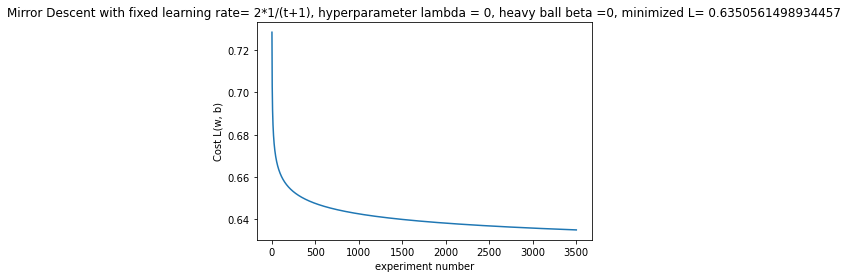

                          leant_weight
age                           0.283846
anaemia                       0.098113
creatinine_phosphokinase      0.050148
diabetes                      0.066577
ejection_fraction             0.007524
high_blood_pressure           0.101367
platelets                     0.062798
serum_creatinine              0.340350
serum_sodium                  0.017575
sex                           0.063125
smoking                       0.050278
time                          0.002005
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 54.  61.]
 [ 24. 110.]]
Accuracy = 0.6586345381526104
 Precision = 0.46956521739130436
 Recall = 0.6923076923076923
 F1_score = 0.5595854922279793
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[10.  9.]
 [ 8. 23.]]
Accuracy = 0.66
 Precision = 0.5263157894736842
 Recall = 0.5555555555555556
 F1_score = 0.5405405405405405
Without heavy ball, With Lasso Regularizati

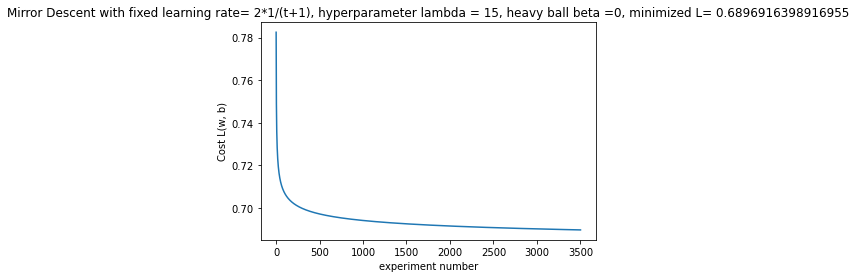

                          leant_weight
age                           0.130469
anaemia                       0.049169
creatinine_phosphokinase      0.034843
diabetes                      0.027012
ejection_fraction             0.003274
high_blood_pressure           0.035552
platelets                     0.017493
serum_creatinine              0.176054
serum_sodium                  0.008389
sex                           0.021018
smoking                       0.025218
time                          0.000767
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 51.  62.]
 [ 27. 109.]]
Accuracy = 0.642570281124498
 Precision = 0.45132743362831856
 Recall = 0.6538461538461539
 F1_score = 0.5340314136125655
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[12. 11.]
 [ 6. 21.]]
Accuracy = 0.66
 Precision = 0.5217391304347826
 Recall = 0.6666666666666666
 F1_score = 0.5853658536585366
**********************************WITH HEAVY

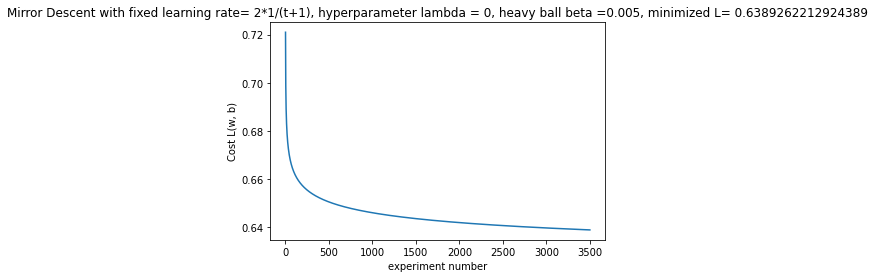

                          leant_weight
age                           0.239297
anaemia                       0.094452
creatinine_phosphokinase      0.087394
diabetes                      0.075970
ejection_fraction             0.011279
high_blood_pressure           0.097963
platelets                     0.049612
serum_creatinine              0.347027
serum_sodium                  0.033126
sex                           0.063105
smoking                       0.062092
time                          0.001949
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 55.  62.]
 [ 23. 109.]]
Accuracy = 0.6586345381526104
 Precision = 0.4700854700854701
 Recall = 0.7051282051282052
 F1_score = 0.5641025641025641
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 9. 10.]
 [ 9. 22.]]
Accuracy = 0.62
 Precision = 0.47368421052631576
 Recall = 0.5
 F1_score = 0.4864864864864865
With heavy ball, With Lasso Regularization
Number of examp

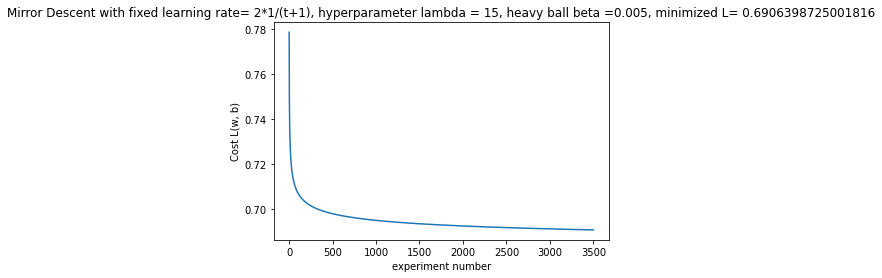

                          leant_weight
age                           0.118356
anaemia                       0.027607
creatinine_phosphokinase      0.032432
diabetes                      0.030155
ejection_fraction             0.004168
high_blood_pressure           0.049811
platelets                     0.021399
serum_creatinine              0.180397
serum_sodium                  0.005838
sex                           0.027051
smoking                       0.031996
time                          0.001107
Performance on the train set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 56.  58.]
 [ 24. 111.]]
Accuracy = 0.6706827309236948
 Precision = 0.49122807017543857
 Recall = 0.7
 F1_score = 0.5773195876288659
Performance on the test set
Confusion Matrix: Rows: y = 1, 0; Columns: y_hat = 1, 0
[[ 8. 12.]
 [ 8. 22.]]
Accuracy = 0.6
 Precision = 0.4
 Recall = 0.5
 F1_score = 0.4444444444444445


In [ ]:
#Callers on the heart failure dataset

#heart_failure_classification(learning_rate, beta, s, n_iter, decay_flag)
#fixed learning rate
print("***********************************WITH FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
heart_failure_classification(0.01, 0, 0, 3500, False, 2)
print("Without heavy ball, With Lasso Regularization")
heart_failure_classification(0.01, 0, 15, 3500, False, 2)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
heart_failure_classification(0.01, 0.005, 0, 3500, False, 2)
print("With heavy ball, With Lasso Regularization")
heart_failure_classification(0.01, 0.005, 15, 3500, False, 2)

#decaying learning rate
print("***********************************DECAYING FIXED STEP SIZE************************************************************")
#Case 1: No heavy ball method
print("**********************************WITHOUT HEAVY BALL************************************************************")
print("Without heavy ball, Without Lasso Regularization")
heart_failure_classification(1, 0, 0, 3500, True, 2)
print("Without heavy ball, With Lasso Regularization")
heart_failure_classification(1, 0, 15, 3500, True, 2)

print("**********************************WITH HEAVY BALL************************************************************")
#Case 2: Heavy ball method
print("Heavy ball method, Without Lasso Regularization")
heart_failure_classification(1, 0.005, 0, 3500, True, 2)
print("With heavy ball, With Lasso Regularization")
heart_failure_classification(1, 0.005, 15, 3500, True, 2) 

In [ ]:
#test block
#1. Correctness of Sigmoid
#x = np.linspace(-10, 10, 1000)
#y = sigmoid(x)
#plt.plot(x,y)

#2. L1 subgradient check
#x = np.linspace(-10, 10, 1000)
#y = subgrad_L1(x)
#plt.plot(x, y)
#plt.plot(0, subgrad_L1(0), 'ro')

#3. testing the divide function
#x = np.random.normal(size=(30, 569))
#y = np.random.normal(size=(1, 569))
#a, b, c, d = divideDataset(x, y, 70)
#print(a.shape)
#print(b.shape)
#print(c.shape)
#print(d.shape)

(569,)
(30, 499)
(1, 499)
(30, 70)
(30, 70)
